------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis/blob/main/code.ipynb)__ 
------------------------------------------------------------------------------------------------------------------------

In [200]:
#this line imports the functions needed for this project
%run code.ipynb

# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Hypothesis

1) Recent (since 1990 ) changes in climate cause more frequent favourable disease events in key phenological stages that potentially lead to infection risk than the years before (1950-1989).

2) However, those changes occur at different intensities across Germany. Higher risks in the more martime regions (higher rainfall &  higher temperature)

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [201]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [202]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (simple_common_stations(simple_common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['02597', '01691', '01550', '05371', '00691', '00701', '03730', '05705', '04371', '02290', '04887', '02601', '03631', '00867', '05906', '00656', '03032', '04104', '01639', '01975', '02261', '02014', '05100', '05792']


### Let's plot the stations to make sure that the points are representative for whole Germany:

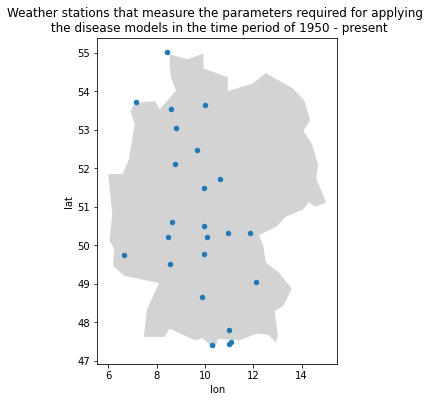

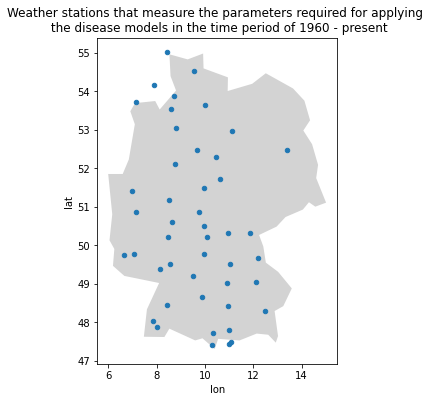

In [203]:
plot_points_germany(1950)
plot_points_germany(1960)


#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

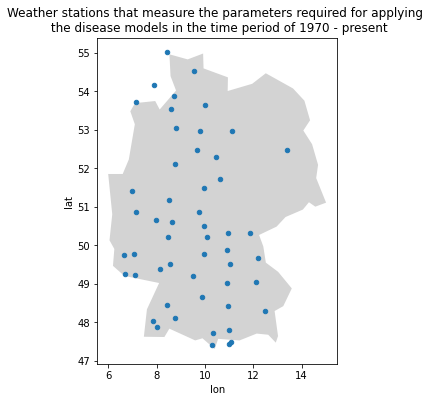

In [204]:
plot_points_germany(1970)


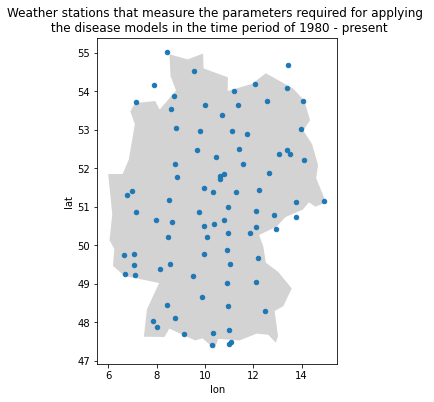

In [205]:
plot_points_germany(1980)

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

## Step 2. Results
### 1. Temperature

In [206]:
df = create_df("air_temperature","hourly",1950,2020,ids = common_ids, is_test=False)
df = df[df["year"] >= 1950]
df = df[df["year"] <= 2019]

All given ids accounted for


Temperature has increased during the last 30 years. However, how does this reflect in plant disease optimal temperature development ?

In [208]:
#def plot_optimal_temperature(df:pd.DataFrame, temp_min:float, temp_max:float, time_start:float,time_min:float):
#    print(temp_range["min"])
#plot_optimal_temperature(22,{"min":15,"maxx":25},{1950,2020})

In [209]:
df["useful_t"] = df.TT_TU.apply(lambda x: 1 if (x >= 15 and x <= 25) else 0)
new_df = df[df["month"].isin([12,1,2,3,4])]
new_df= new_df.groupby(["year"]).mean()
avg50_79= new_df[new_df.index <= 1979]["useful_t"].mean()
max50_79 = new_df[new_df.index <= 1979]["useful_t"].max()
min50_79 = new_df[new_df.index <= 1979]["useful_t"].min()
new_df['7yrs_average'] = new_df.useful_t.rolling(7).mean()
#print(new_df)



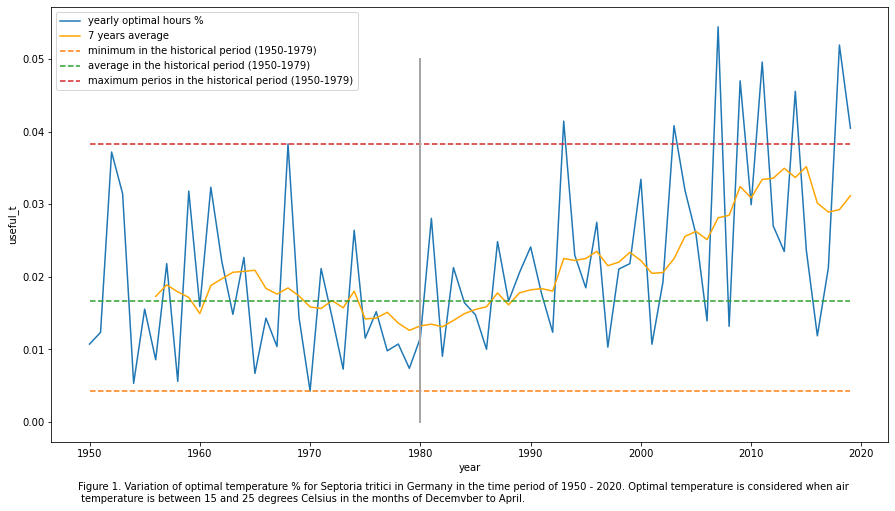

In [210]:
plt.figure(figsize = (15,8))
sns.lineplot(x = 'year', y = 'useful_t',data = new_df, label="yearly optimal hours %")
sns.lineplot(x = 'year', y = '7yrs_average',data = new_df, label="7 years average", color = "orange")
sns.lineplot(x = new_df.index, y = min50_79,linestyle="dashed", label="minimum in the historical period (1950-1979)")
sns.lineplot(x = new_df.index, y = avg50_79,linestyle="dashed", label="average in the historical period (1950-1979)")
sns.lineplot(x = new_df.index, y = max50_79, linestyle="dashed", label="maximum perios in the historical period (1950-1979)")

plt.plot([1980,1980], [-0.00,0.05], lw=2, color = "0.65", label = "historical period (left)")
#plt.figtext(1980, 0.06, "Historical period " )

plt.figtext(0.15, 0.021, "Figure 1. Variation of optimal temperature % for Septoria tritici in Germany in the time period of 1950 - 2020. Optimal temperature is considered when air \n temperature is between 15 and 25 degrees Celsius in the months of Decemvber to April. " )
plt.show()

In [211]:
import plotly_express as px
fig = px.line(x=new_df.index, 
    y=[new_df.useful_t,
        new_df["7yrs_average"],
        [max50_79 for x in new_df.useful_t],
        [avg50_79 for x in new_df.useful_t],
        [min50_79 for x in new_df.useful_t],
        ],template="simple_white")
#fig.add_hline(y=max50_79)
newnames = {'wide_variable_0':'yearly optimal hours %',
             'wide_variable_1': '7yrs_average',
             'wide_variable_2': 'max',
             'wide_variable_3': 'average',
             'wide_variable_4': 'dunno'}
fig.for_each_trace(lambda t:t.update(name = newnames[t.name]))

fig.update_layout(
    title="Plot Title",
    xaxis_title="year",
    yaxis_title="% of hours with optimal temperature for Septoria",
    legend_title="Legend",
    font=dict(
        #family="Courier New, monospace",
        size=12,
        color="#4d4d4d"
    )
)
fig.show()

I will try now to attempt to model using CO2 emmisions:

https://ourworldindata.org/co2-and-other-greenhouse-gas-emissions

### 2. Leaf wetness

In [212]:
df3= create_df("moisture","hourly",1950,2020,ids = common_ids, is_test=False)

All given ids accounted for


In [213]:

#df3["decade"] = df3["year"].apply(lambda x: str(x)[:3]+"0'")
new_df3 = df3[df3["month"].isin([12,1,2,3,4])]
new_df3.drop(["QN_8","eor","ABSF_STD","VP_STD","TF_STD","P_STD","TT_STD"], inplace=True,axis=1)
new_df3 = df3[df3["month"].isin([12,1,2,3,4])]
col_list = []
for i in range(87,93):
    new_df3[f"lw{i}"]=new_df3["RF_STD"].apply(lambda x: 1 if float(x) >= i else 0)
new_df3["RH_average"]= new_df3[[f"lw{i}" for i in range(87,93)]].mean(axis=1)
#new_df3= new_df3.groupby("decade").mean()
new_df3= new_df3.groupby("year").mean()


/var/folders/yd/1zxj_l9n3b31td3r6z9lbz9m0000gp/T/ipykernel_1766/1493369707.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yd/1zxj_l9n3b31td3r6z9lbz9m0000gp/T/ipykernel_1766/1493369707.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/var/folders/yd/1zxj_l9n3b31td3r6z9lbz9m0000gp/T/ipykernel_1766/1493369707.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

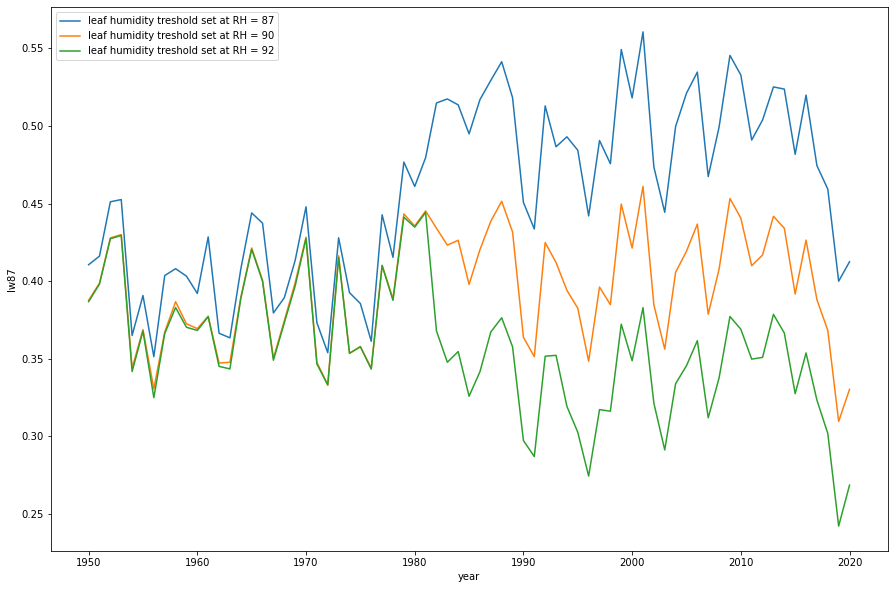

In [214]:
plt.figure(figsize = (15,10))
#avg50_79= new_df3[new_df3.index <= 1979]["RH_STD"].mean()
#sns.lineplot(x="year", y = "RH_average",data= new_df3, label = f"Average from RH in range 87-92")
for i in [87,90,92]:
    sns.lineplot( x="year", y = f"lw{i}", data= new_df3, label= f"leaf humidity treshold set at RH = {i}")


### I conclude that I must really calibrate the model: the differences are huge between 87 and 93% RH so

## Negative forecast
https://journals.ametsoc.org/view/journals/apme/30/4/1520-0450_1991_030_0463_trhdff_2_0_co_2.xml

/var/folders/yd/1zxj_l9n3b31td3r6z9lbz9m0000gp/T/ipykernel_1766/2033629579.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='year', ylabel='dry_leaf'>

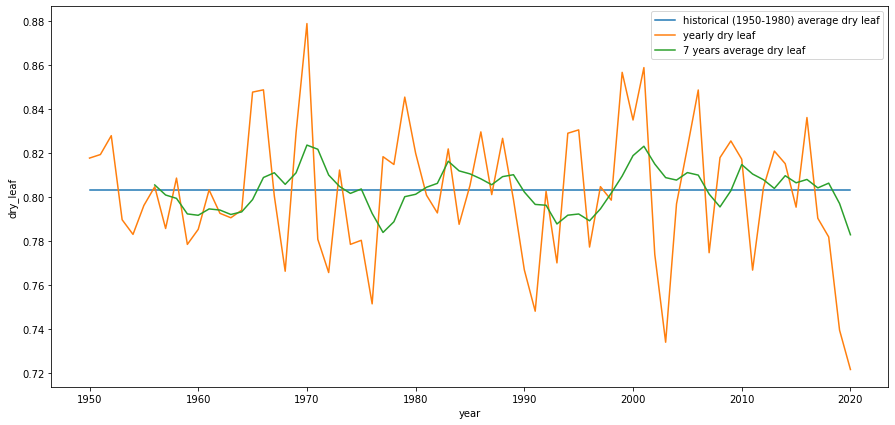

In [215]:
new_df3 = df3[df3["month"].isin([12,1,2,3,4])]

new_df3[f"dry_leaf"]=new_df3["RF_STD"].apply(lambda x: 1 if float(x) >= 70 else 0)
#new_df3["RH_average"]= new_df3[[f"lw{i}" for i in range(87,93)]].mean(axis=1)
new_df3= new_df3.groupby("year").mean()
new_df3['7yrs_average'] = new_df3.dry_leaf.rolling(7).mean()
avg50_79= new_df3[new_df3.index <= 1979]["dry_leaf"].mean()

plt.figure(figsize = (15,7))
sns.lineplot( x=new_df3.index, y = avg50_79 , label = "historical (1950-1980) average dry leaf")
sns.lineplot( x="year", y = "dry_leaf", data= new_df3, label = "yearly dry leaf")
sns.lineplot( x="year", y = '7yrs_average', data= new_df3, label = "7 years average dry leaf")

# Leaf wetness model 2

"The difference between T and dew point temperature (Td) is the dew point depression (DPD) which has also been suggested as a LWD estimator by Huber and Gillespie (1992) and Gillespie et al. (1993), based on the same observations done by Monteith (1957) in relation to RH. Duration of wetness is estimated as the length of time that DPD remains between two specific limits. The wetness criteria for this study were DPD ≤ 1.8 °C for wetness onset and DPD ≥ 2.2 °C for wetness dry-off (Rao et al., 1998)."

In [216]:
df4 = create_df("dew_point","hourly",1950,2020,ids = common_ids, is_test=False)
df_dpd.columns = [col.strip() for col in df_dpd.columns]

All given ids accounted for


      STATIONS_ID  MESS_DATUM   QN_8     TT     TD    eor  month    day   hour
year                                                                          
1950        78404       78404  78404  78404  78404  78404  78404  78404  78404
1951        82700       82700  82700  82700  82700  82700  82700  82700  82700
1952        82699       82699  82699  82699  82699  82699  82699  82699  82699
1953        81635       81635  81635  81635  81635  81635  81635  81635  81635
1954        80204       80204  80204  80204  80204  80204  80204  80204  80204
1955        79218       79218  79218  79218  79218  79218  79218  79218  79218
1956        77521       77521  77521  77521  77521  77521  77521  77521  77521
1957        76104       76104  76104  76104  76104  76104  76104  76104  76104
1958        76418       76418  76418  76418  76418  76418  76418  76418  76418
1959        75548       75548  75548  75548  75548  75548  75548  75548  75548


<AxesSubplot:xlabel='year', ylabel='TD'>

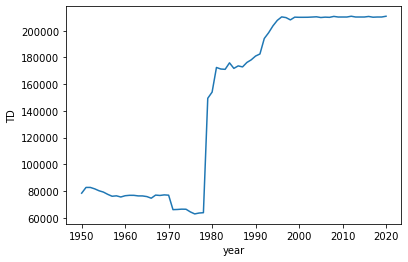

In [217]:
df_dpd = df4.copy()
measures = df_dpd.groupby("year").count()
print(measures.head(10))
measures.columns = [col.strip() for col in measures.columns]

sns.lineplot(x=measures.index,y=measures.TD)

Again, I can not apply the model and look for consecutive times with leaf wetness because until 1990 the dew point is measured every 3 hours. But we can work with %.

In [218]:

df_dpd["difference"]=df_dpd.apply(lambda x: (x['TT']- x['TD']), axis=1)
df_dpd= df_dpd[df_dpd["month"].isin([12,1,2,3,4])]
df_dpd = df_dpd.groupby("year").mean()
avg50_79= df_dpd[df_dpd.index <= 1979]["difference"].mean()
max50_79 = df_dpd[df_dpd.index <= 1979]["difference"].max()
min50_79 = df_dpd[df_dpd.index <= 1979]["difference"].min()
df_dpd['7yrs_average'] = df_dpd.difference.rolling(7).mean()

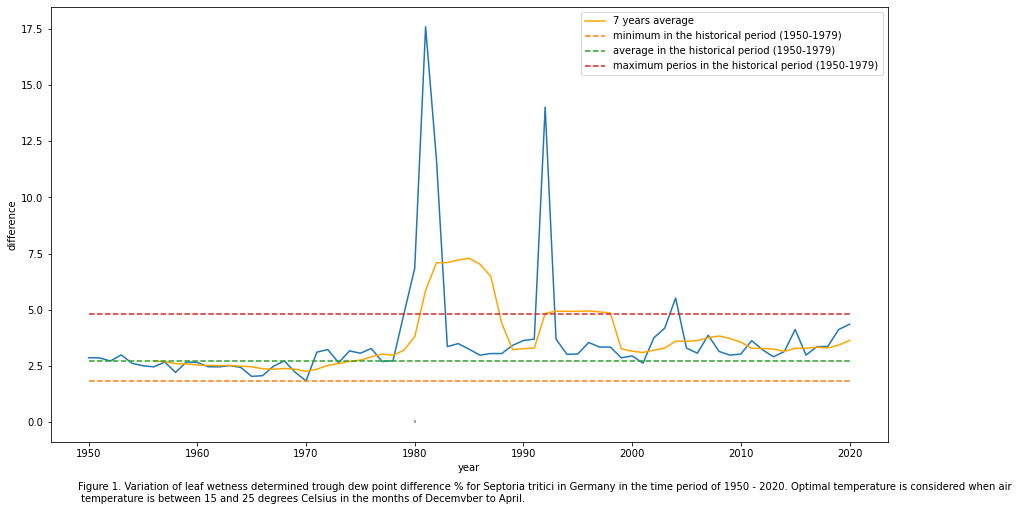

In [219]:

plt.figure(figsize = (15,8))

sns.lineplot(x=df_dpd.index, y= df_dpd["difference"])#, label = "average yearly difference")
sns.lineplot(x = df_dpd.index, y = df_dpd['7yrs_average'], label="7 years average", color = "orange")
sns.lineplot(x = df_dpd.index, y = min50_79,linestyle="dashed", label="minimum in the historical period (1950-1979)")
sns.lineplot(x = df_dpd.index, y = avg50_79,linestyle="dashed", label="average in the historical period (1950-1979)")
sns.lineplot(x = df_dpd.index, y = max50_79, linestyle="dashed", label="maximum perios in the historical period (1950-1979)")

plt.plot([1980,1980], [-0.00,0.05], lw=2, color = "0.65", label = "historical period (left)")
#plt.figtext(1980, 0.06, "Historical period " )

plt.figtext(0.15, 0.021, "Figure 1. Variation of leaf wetness determined trough dew point difference % for Septoria tritici in Germany in the time period of 1950 - 2020. Optimal temperature is considered when air \n temperature is between 15 and 25 degrees Celsius in the months of Decemvber to April. " )
plt.show()

In [220]:
df_dpd = df4.copy()
